<h4>gesture data capturing xyz acceleration</h4>
<p>
0 walking, 1 walking upstairs, 2 walking downstairs<br>
3 sitting, 4 standing 5 laying
</p>

In [1]:
# UCI_HAR_Dataset
# dirty code
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:

# making train data
path = "/home/sk/data/gesture_xyz/train/Inertial_Signals/"
ax = np.loadtxt(path+"body_acc_x_train.txt");
ay = np.loadtxt(path+"body_acc_y_train.txt")
az = np.loadtxt(path+"body_acc_z_train.txt")
print(ax.shape)
path_label = "/home/sk/data/gesture_xyz/train/y_train.txt"
y_train = np.loadtxt(path_label); y_train = np.array(y_train,int)
# 1-6 -> 0-5
y_train[:] = y_train[:]-1
# one-hot
#y_train =  np.eye(6)[y_train]

ax = np.reshape(ax,(7352,128,1))
ay = np.reshape(ay,(7352,128,1))
az = np.reshape(az,(7352,128,1))

print(ax.shape)
# 3ch data
acc = ax.copy()
acc = np.append(acc,ay,axis=2)
acc = np.append(acc,az,axis=2)
#acc = np.transpose(acc,(1,0,2))
X_train = acc
print("(seq_len, bt_size, vec_size)")
print(X_train.shape)

(7352, 128)
(7352, 128, 1)
(seq_len, bt_size, vec_size)
(7352, 128, 3)


In [3]:
# making test data
path = "/home/sk/data/gesture_xyz/test/Inertial_Signals/"
ax = np.loadtxt(path+"body_acc_x_test.txt")
ay = np.loadtxt(path+"body_acc_y_test.txt")
az = np.loadtxt(path+"body_acc_z_test.txt")
path_label = "/home/sk/data/gesture_xyz/test/y_test.txt"
y_test = np.loadtxt(path_label); y_test = np.array(y_test,int)
# 1-6 -> 0-5
y_test[:] = y_test[:]-1
# one-hot
#y_test =  np.eye(6)[y_test]

# 3ch data
ax = np.reshape(ax,(2947,128,1))
ay = np.reshape(ay,(2947,128,1))
az = np.reshape(az,(2947,128,1))
acc = ax.copy()
acc = np.append(acc,ay,axis=2)
acc = np.append(acc,az,axis=2)
#acc = np.transpose(acc,(1,0,2))
X_test = acc
print("(seq_len, bt_size, vec_size)")
print(X_test.shape)
print(y_test.shape)

(seq_len, bt_size, vec_size)
(2947, 128, 3)
(2947,)


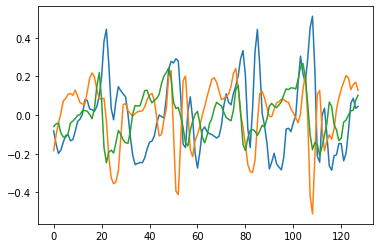

In [4]:
num_samp = np.arange(0,X_test.shape[1]) 

i = 100
plt.plot(num_samp,ax[i,:])
plt.plot(num_samp,ay[i,:])
plt.plot(num_samp,az[i,:])
plt.show()

In [5]:
class MyLSTM(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(MyLSTM, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0) #LSTM層
        output = self.dropout(output)
        output = self.output_layer(output[:, -1, :]) #全結合層
        
        return output

In [6]:
def makeRandomBatch(train_x, train_y, batch_size=50):
    
    batch_x, batch_y = [], []
    
    for _ in range(batch_size):
        
        idx = np.random.randint(0,len(train_x) -1)
        batch_x.append(train_x[idx])
        batch_y.append(train_t[idx])
        
    return torch.tensor(batch_x), torch.tensor(batch_t)

In [7]:
# def cross_entropy_one_hot(input,target): # 多分one_hotにする必要がない(後で書き換える)
#     _, labels = target.max(dim=0)
#     return nn.CrossEntropyLoss()(input,labels)

In [8]:
import torch.optim as optim

input_vec_size = 3
hidden_size = 32
out_dim = 6

epoch_num = 2
training_size = 7352
test_size = 2947
batch_size = 25

model = MyLSTM(input_vec_size, hidden_size,out_dim)
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [9]:
from torch.autograd import Variable

epochs_num = 100
best_acc = 0

trn_accs = []
val_accs = []
batch_size = 50
for epoch in range(epochs_num):
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    
    # shuffle and make batch
    shuffle_indices = np.random.permutation(np.arange(training_size))
    X_train = X_train[shuffle_indices]; y_train = y_train[shuffle_indices]
    
    for i in range(int(training_size / batch_size)):
        model.train()
        optimizer.zero_grad()
        
        startId = i * batch_size; endId = min( (i+1)*batch_size,training_size )
        
        # making batch and to cuda
        data = X_train[startId:endId]; label = y_train[startId:endId]
        data = torch.tensor(data); label= torch.tensor(label)
        data, label = Variable(data.cuda()), Variable(label.cuda())

        # output and loss
        output = model(data.float())
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        training_accuracy += (predicted == label).sum().item()
        #print(output.data,label.data)

        #training_accuracy += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)

    #test
    test_accuracy = 0.0
    for i in range(int(test_size / batch_size)):
        model.eval()
        offset = i * batch_size
        data, label = torch.tensor(X_test[offset:offset+batch_size]), torch.tensor(y_test[offset:offset+batch_size])
        data, label = data.cuda(), label.cuda()
        #data = data.to(device); label = label.to(device)
        output = model(data.float(), None)

        _, predicted = torch.max(output.data, 1)
        test_accuracy += (predicted == label).sum().item()

#           test_accuracy += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)
    training_accuracy /= training_size; trn_accs.append(training_accuracy)
    test_accuracy /= test_size; val_accs.append(test_accuracy)

    if test_accuracy > best_acc:
            best_acc = test_accuracy
            best_model_wts = model.state_dict().copy()
#                best_model_wts = copy(model.state_dict())
#             print("best val")

#     print('%d loss: %.3f, training_accuracy: %.5f, test_accuracy: %.5f' % (
#         epoch + 1, running_loss, training_accuracy, test_accuracy))

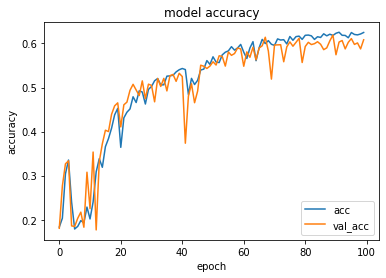

In [10]:
# 精度の履歴をプロット
plt.plot()
plt.plot(trn_accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

In [11]:
test_accuracy = 0.0
batch_size = 1

y_pred = []
for i in range(int(test_size / batch_size)):
    offset = i * batch_size
    data, label = torch.tensor(X_test[offset:offset+batch_size]), torch.tensor(y_test[offset:offset+batch_size])
    data, label = data.cuda(), label.cuda()
    #data = data.to(device); label = label.to(device)
    output = model(data.float(), None)

    _, predicted = torch.max(output.data, 1); y_pred.append(predicted.cpu().numpy())
    test_accuracy += (predicted == label).sum().item()

test_accuracy /= test_size
print(test_accuracy)

0.6243637597556837


In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[493,   3,   0,   0,   0,   0],
       [ 39, 421,  11,   0,   0,   0],
       [  7,  26, 387,   0,   0,   0],
       [  0,   0,   0,   0,   5, 486],
       [  0,   0,   0,   0,  11, 521],
       [  0,   1,   0,   0,   8, 528]])